<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/10_note_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Density Based Clustering Part2

160. Density based clustering validation (DBCV) - part 1
161. Density based clustering validation (DBCV) - part 2
162. Demo: Implementing DBCV from scratch - part 1
163. Demo: Implementing DBCV from scratch - part 2 + DBCV python function
164. DBSCAN general guideliness
165. Demo: Clustering digits (mnist784) with DBSCAN
166. Demo: Clustering animals with DBSCAN (categorical data)
167. HDBSCAN clustering algorithm - part 1
168. HDBSCAN clustering algorithm - part 2
169. HDBSCAN clustering algorithm - part 3

#### HDBSCAN

HDBSCAN (hierarchical density-based spatial clustering of applications with noise)
- hierarchical、density-based clustering 方法
- 產出 density-based clustering hierarchy, 從其中發現 cluster 和 noise

core distances:

$core\_dist(o)=KNN(o, min\_samples)$

- (inverse) density 的估計

mutual reachability distance:

$reach\_dist(i, j)=max(core\_dist(i), core\_dist(j), dist(i, j))$

- 考慮 density 的 point 之間的 symmetric 距離
- reachability distance 小: $i, j$ 的 deisnty 高 && 距離近

mutual reachability graph:
- 以 mutual reachability distance 作為 edge weight 的 fully connected undirected graph

mutual reachability graph minimum spanning tree:
- 描述了 dataset 的 density backbone

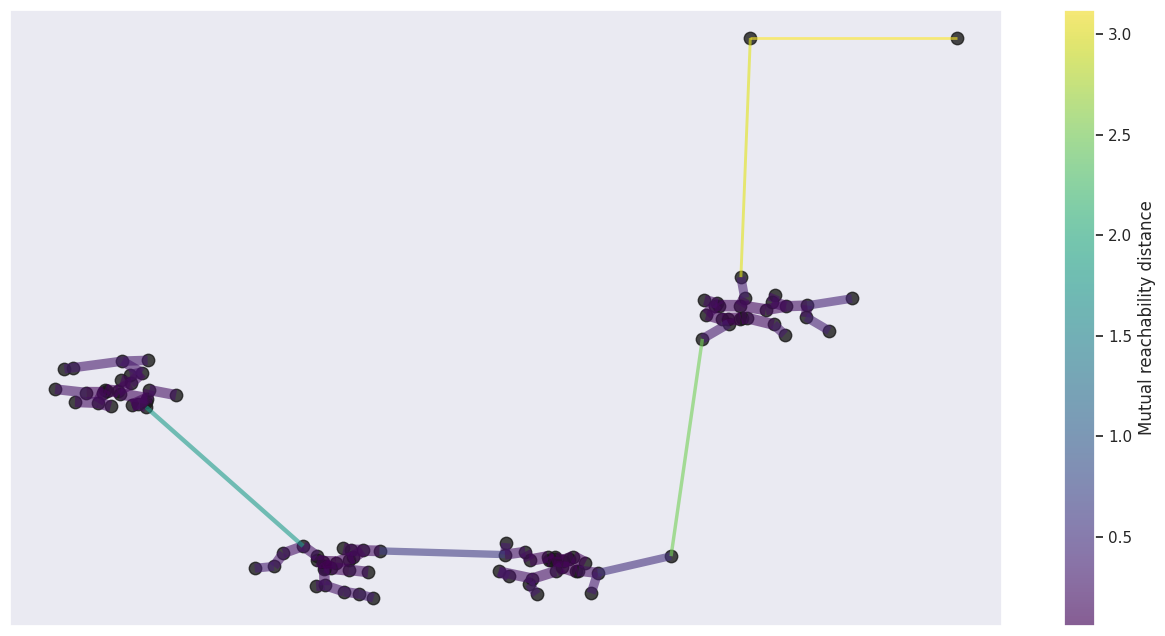

建立 dendrogram:
- 從 MST 的 edge weight (reachability distance) 由小到大 merge node (point) 的所屬 group
    - 等同 (?) 用 single-linkage 來建立 dendrogram

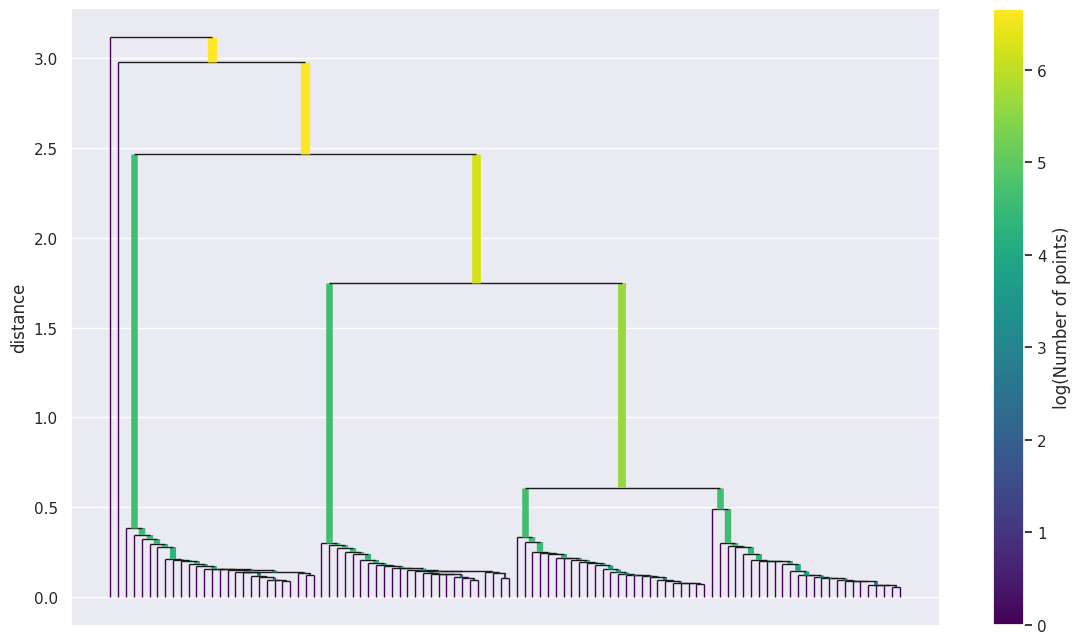

DBSCAN*:
- 只有 core point、noise 的概念
- cluster 為 density level set 的連通部分

在 level `eps` 對 dendrogram 切割得到 clustering (global density threshold)
- 等同 mutual reachability graph 移除 weight > `eps` 的 edge 得到的連通部分
- 等同 parameter 為 `min_samples`、`eps` 的 DBSCAN*
- HDBSCAN 為 hierarchical DBSCAN*

condensed tree:
- 由上往下, 對每個 split node
  - 若兩個 branch 的 point 數目都 > `min_cluster_size`, 則維持拆分的 branch
  - 否則壓縮顯示為一個隨 density 的增加, 有 point leaking 的 cluster

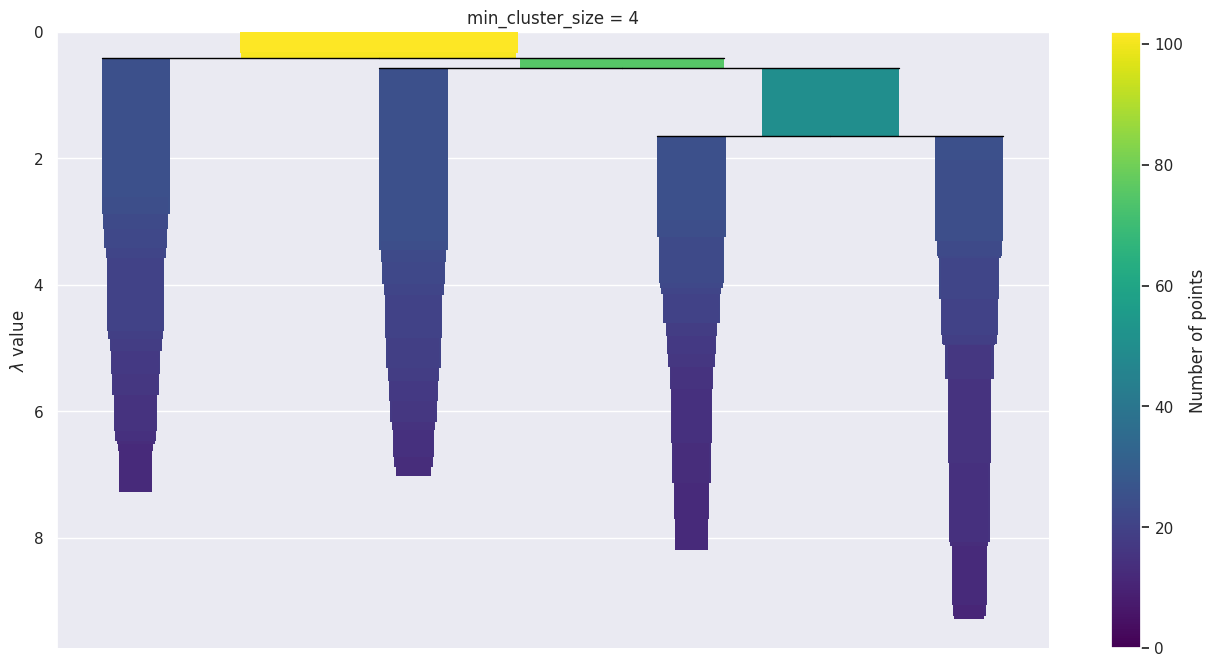

cluster stability:
- $\lambda=1/distance$
- $\lambda_{birth}$: branch 開始的 $\lambda$
- $\lambda_{death}$: branch 結束的 $\lambda$
- $\lambda_{p}$: leakage event 發生的 $\lambda$
- $\sum_{p \in cluster} (\lambda_p-\lambda_{birth})$

excess of mass:
- leaf 標記為 cluster
- 由下往上, 對每個拆分點
  - 如果 child cluster 的 stability sum > 拆分點的 stability, 則 child branch 標記為 cluster
  - 否則拆分點標記為 cluster, child cluster 取消 cluster 標記
- 最後有標記的 cluster 為最穩定的 clustering

leaf method:
- leaf 形成 cluster

cluster_selection_epsilon:
- 若兩個 branch 的 distance < 此值, 則視為一個 cluster

parameters:
- min_samples: 計算 core distance
- min_cluster_size: 建構 condensed tree 時用到

#### Density based clustering validation (DBCV)

core distance:

$\LARGE core\_dist(o)=\left(\frac{\sum_{i=2}^{n_i}\left(\frac{1}{dist(o, i)}\right)^d}{n_i-1}\right)^{-\frac{1}{d}}$

- (inverse) density 的估計
- 鄰近 cluster point 的貢獻較大
- 可與距離比較
  - $KNN(o, 2) \le core\_dist(o) \le KNN(o, n)$

mutual reachability distance:

$reach\_dist(i, j)=max(core\_dist(i), core\_dist(j), dist(i, j))$

- 考慮 density 的 point 之間的 symmetric 距離
- reachability distance 小: $i, j$ 的 deisnty 高 && 距離近

mutual reachability graph:
- 針對每個 cluster, 以 mutual reachability distance 作為 edge weight 的 fully connected undirected graph

mutual reachability graph minimum spanning tree:
- 捕捉了 cluster 的 connectivity (形狀、density)
- internal node: degree > 1
- internal edge: 端點不是 internal node
- internal edge 描述了 cluster 的主幹

cluster density sparseness:
- 針對每個 cluster, 計算 MST 中 internal edge 的最大 weight
- cluster 內最低 density 的區域

cluster density separation:
- $density\_separation(C_i, C_j)$: cluster $C_i$ 和 $C_j$ 的 MST 的 internal node 間的最小 reachability distance
  - cluster $C_i$ 和 $C_j$ 間最高 density 的區域
- 針對每個 cluster $C_i$, 計算 $\min_{1 \le j \le k, j \neq i} density\_separation(C_i, C_j)$

cluster validation coefficient:

$\Large clust\_val\_coef=\frac{clust\_density\_separation-clust\_density\_sparseness}{max(clust\_density\_separation, clust\_density\_sparseness)}$
- range: $[-1, 1]$

DBCV:

$\Large \sum_{i}\left(\frac{number\_of\_points\_in\_cluster_j}{total\_number\_of\_points} \times cluster\_validation\_coef_i\right)$
- range: $[-1, 1]$

#### DBSCAN 小結

mnist784 clustering 結果

categorical data (animals) clustering 結果

pros:

cons:

#### API - DBCV

<font size='4'>


```python
hdbscan.validity.validity_index(X, labels, metric='euclidean', d=None,
  per_cluster_scores=False, mst_raw_dist=False, verbose=False, **kwd_args)
```

</font>

- `d`: `metric='precomputed'` 時, 界定 feature 的個數
- `mst_raw_dist=True`: reachability distance 等同 raw distance

methods:

<font size='4'>


```python
fit(X, sample_weight=None)
fit_predict(X, sample_weight=None)
```

</font>


attributes:

<font size='4'>


```python
core_sample_indices_ # core point 的索引
labels_ # cluster id (noise point 為 -1)
```

</font>
